In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

import torchvision
import torchvision.transforms as transforms
from tqdm import trange

In [18]:
# Hyperparameters for training
num_rounds = 50
lr = 0.0001
num_channels = 3
num_classes = 10
test_bs = 128

In [19]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda', index=5)

In [21]:
#ResNet9
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [22]:
class ResNet9(nn.Module):
    def __init__(
            self, 
            in_channels, 
            num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [23]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

In [24]:
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                       transforms.RandomCrop(32, padding=4),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
#                                      std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])

In [25]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [26]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_bs, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Initialize and synchronize models###
global_model = ResNet9(in_channels=num_channels, num_classes=num_classes).to(device)
# optimizer = torch.optim.SGD(global_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(global_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
criterion = nn.CrossEntropyLoss()
              
# client_models = [ResNet18(
#     in_channels=num_channels, num_classes=num_classes).to(device) for _ in range(num_clients)]
# optimizers=[torch.optim.Adam(model.parameters(), lr=lr) for model in client_models]
# schedulers = [torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma) for optimizer in optimizers]
# for model in client_models:
#   model.load_state_dict(global_model.state_dict())

In [28]:
# global_model.to(device)
# summary(global_model, (3, 32, 32))

In [29]:
# Training function
def train(model: nn.Module, loader: DataLoader, optimizer, criterion):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        _, pred = torch.max(output, dim=1)
        correct_train = pred.eq(target.data.view_as(pred))
        accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
        epoch_acc.append(accuracy_train.item())
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

In [30]:
# Evaluate on Test dataset
def evaluate(global_model, data_loader, device):
    global_model.eval()
    # testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            log_probs = global_model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)
                                 ).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss

In [31]:
global_model.train()
loss_train = []
loss_test = []
acc_train = []
acc_test= []

# Early stopping
patience = 10 
patience_counter = 0


for round in trange(num_rounds):
    # Train on local data
    w, loss, acc = train(global_model, trainloader, optimizer, criterion)
    loss_train.append(loss)
    acc_train.append(100 * acc)

    # Evaluation on test dataset for each round
    cur_auc, test_loss = evaluate(global_model, testloader, device)
    loss_test.append(test_loss)
    acc_test.append(cur_auc)
    print(f'Round {round+1}, Train loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')
    ## Early Stopping
    valid_loss_array = np.array(loss_test)
    min_valid_loss = np.min(valid_loss_array)
    
    if(test_loss > min_valid_loss):
        patience_counter += 1        
    else:
        patience_counter = 0       #setting the patience counter to zero if the test loss improves again 
    
    ## Calling early stopping if test loss doest improves from last (patience) Iterations
    if(patience_counter > patience):
        print("Early stopping called at {} epochs".format(round+1))
        # break
    scheduler.step()


  2%|▏         | 1/50 [00:07<06:04,  7.44s/it]

Round 1, Train loss: 1.7025, Test Loss: 1.1969, Test Accuracy: 57.21%


  4%|▍         | 2/50 [00:14<05:56,  7.42s/it]

Round 2, Train loss: 1.2131, Test Loss: 0.9761, Test Accuracy: 65.29%


  6%|▌         | 3/50 [00:22<05:49,  7.44s/it]

Round 3, Train loss: 1.0149, Test Loss: 0.8709, Test Accuracy: 69.26%


  8%|▊         | 4/50 [00:29<05:42,  7.45s/it]

Round 4, Train loss: 0.8830, Test Loss: 0.7818, Test Accuracy: 72.84%


 10%|█         | 5/50 [00:37<05:36,  7.47s/it]

Round 5, Train loss: 0.7875, Test Loss: 0.7462, Test Accuracy: 74.37%


 12%|█▏        | 6/50 [00:44<05:28,  7.47s/it]

Round 6, Train loss: 0.7165, Test Loss: 0.7580, Test Accuracy: 74.66%


 14%|█▍        | 7/50 [00:52<05:21,  7.48s/it]

Round 7, Train loss: 0.6616, Test Loss: 0.6208, Test Accuracy: 78.84%


 16%|█▌        | 8/50 [00:59<05:14,  7.49s/it]

Round 8, Train loss: 0.6193, Test Loss: 0.6606, Test Accuracy: 77.20%


 18%|█▊        | 9/50 [01:07<05:07,  7.49s/it]

Round 9, Train loss: 0.5758, Test Loss: 0.5858, Test Accuracy: 79.78%


 20%|██        | 10/50 [01:14<05:00,  7.51s/it]

Round 10, Train loss: 0.5390, Test Loss: 0.5821, Test Accuracy: 80.31%


 22%|██▏       | 11/50 [01:22<04:53,  7.52s/it]

Round 11, Train loss: 0.5066, Test Loss: 0.5615, Test Accuracy: 81.16%


 24%|██▍       | 12/50 [01:29<04:45,  7.53s/it]

Round 12, Train loss: 0.4738, Test Loss: 0.6025, Test Accuracy: 79.79%


 26%|██▌       | 13/50 [01:37<04:38,  7.53s/it]

Round 13, Train loss: 0.4558, Test Loss: 0.5285, Test Accuracy: 82.07%


 28%|██▊       | 14/50 [01:44<04:31,  7.53s/it]

Round 14, Train loss: 0.4328, Test Loss: 0.6208, Test Accuracy: 80.18%


 30%|███       | 15/50 [01:52<04:23,  7.54s/it]

Round 15, Train loss: 0.4091, Test Loss: 0.5437, Test Accuracy: 81.86%


 32%|███▏      | 16/50 [02:00<04:16,  7.54s/it]

Round 16, Train loss: 0.3914, Test Loss: 0.5249, Test Accuracy: 82.54%


 34%|███▍      | 17/50 [02:07<04:09,  7.55s/it]

Round 17, Train loss: 0.3734, Test Loss: 0.7749, Test Accuracy: 76.99%


 36%|███▌      | 18/50 [02:15<04:01,  7.56s/it]

Round 18, Train loss: 0.3572, Test Loss: 0.5271, Test Accuracy: 82.10%


 38%|███▊      | 19/50 [02:22<03:54,  7.55s/it]

Round 19, Train loss: 0.3388, Test Loss: 0.4778, Test Accuracy: 84.44%


 40%|████      | 20/50 [02:30<03:46,  7.56s/it]

Round 20, Train loss: 0.3251, Test Loss: 0.4435, Test Accuracy: 84.83%


 42%|████▏     | 21/50 [02:37<03:39,  7.55s/it]

Round 21, Train loss: 0.3082, Test Loss: 0.4473, Test Accuracy: 85.41%


 44%|████▍     | 22/50 [02:45<03:31,  7.56s/it]

Round 22, Train loss: 0.2960, Test Loss: 0.5326, Test Accuracy: 83.30%


 46%|████▌     | 23/50 [02:52<03:23,  7.55s/it]

Round 23, Train loss: 0.2841, Test Loss: 0.4587, Test Accuracy: 85.15%


 48%|████▊     | 24/50 [03:00<03:16,  7.55s/it]

Round 24, Train loss: 0.2715, Test Loss: 0.4418, Test Accuracy: 85.29%


 50%|█████     | 25/50 [03:08<03:08,  7.55s/it]

Round 25, Train loss: 0.2590, Test Loss: 0.5174, Test Accuracy: 83.66%


 52%|█████▏    | 26/50 [03:15<03:01,  7.55s/it]

Round 26, Train loss: 0.2497, Test Loss: 0.4112, Test Accuracy: 86.86%


 54%|█████▍    | 27/50 [03:23<02:53,  7.55s/it]

Round 27, Train loss: 0.2359, Test Loss: 0.4378, Test Accuracy: 86.35%


 56%|█████▌    | 28/50 [03:30<02:46,  7.55s/it]

Round 28, Train loss: 0.2267, Test Loss: 0.4349, Test Accuracy: 86.42%


 58%|█████▊    | 29/50 [03:38<02:39,  7.59s/it]

Round 29, Train loss: 0.2174, Test Loss: 0.5869, Test Accuracy: 82.25%


 60%|██████    | 30/50 [03:46<02:31,  7.59s/it]

Round 30, Train loss: 0.2139, Test Loss: 0.5779, Test Accuracy: 83.38%


 62%|██████▏   | 31/50 [03:53<02:24,  7.60s/it]

Round 31, Train loss: 0.2024, Test Loss: 0.6581, Test Accuracy: 81.01%


 64%|██████▍   | 32/50 [04:01<02:17,  7.62s/it]

Round 32, Train loss: 0.1926, Test Loss: 0.4483, Test Accuracy: 85.90%


 66%|██████▌   | 33/50 [04:08<02:09,  7.61s/it]

Round 33, Train loss: 0.1883, Test Loss: 0.3943, Test Accuracy: 88.18%


 68%|██████▊   | 34/50 [04:16<02:01,  7.60s/it]

Round 34, Train loss: 0.1774, Test Loss: 0.4781, Test Accuracy: 85.35%


 70%|███████   | 35/50 [04:24<01:53,  7.59s/it]

Round 35, Train loss: 0.1677, Test Loss: 0.4448, Test Accuracy: 86.44%


 72%|███████▏  | 36/50 [04:31<01:46,  7.58s/it]

Round 36, Train loss: 0.1573, Test Loss: 0.5161, Test Accuracy: 84.94%


 74%|███████▍  | 37/50 [04:39<01:38,  7.58s/it]

Round 37, Train loss: 0.1546, Test Loss: 0.4996, Test Accuracy: 85.63%


 76%|███████▌  | 38/50 [04:46<01:30,  7.57s/it]

Round 38, Train loss: 0.1506, Test Loss: 0.4273, Test Accuracy: 87.18%


 78%|███████▊  | 39/50 [04:54<01:23,  7.57s/it]

Round 39, Train loss: 0.1466, Test Loss: 0.5141, Test Accuracy: 84.86%


 80%|████████  | 40/50 [05:01<01:15,  7.56s/it]

Round 40, Train loss: 0.1385, Test Loss: 0.4240, Test Accuracy: 87.16%


 82%|████████▏ | 41/50 [05:09<01:08,  7.56s/it]

Round 41, Train loss: 0.1332, Test Loss: 0.4621, Test Accuracy: 86.62%


 84%|████████▍ | 42/50 [05:16<01:00,  7.55s/it]

Round 42, Train loss: 0.1256, Test Loss: 0.5735, Test Accuracy: 84.47%


 86%|████████▌ | 43/50 [05:24<00:52,  7.55s/it]

Round 43, Train loss: 0.1223, Test Loss: 0.4100, Test Accuracy: 87.43%


 88%|████████▊ | 44/50 [05:31<00:45,  7.55s/it]

Round 44, Train loss: 0.1233, Test Loss: 0.4153, Test Accuracy: 87.69%
Early stopping called at 44 epochs


 90%|█████████ | 45/50 [05:39<00:37,  7.55s/it]

Round 45, Train loss: 0.1139, Test Loss: 0.4479, Test Accuracy: 86.59%
Early stopping called at 45 epochs


 92%|█████████▏| 46/50 [05:47<00:30,  7.54s/it]

Round 46, Train loss: 0.1072, Test Loss: 0.6246, Test Accuracy: 83.37%
Early stopping called at 46 epochs


 94%|█████████▍| 47/50 [05:54<00:22,  7.55s/it]

Round 47, Train loss: 0.1039, Test Loss: 0.4908, Test Accuracy: 86.11%
Early stopping called at 47 epochs


 96%|█████████▌| 48/50 [06:02<00:15,  7.55s/it]

Round 48, Train loss: 0.1049, Test Loss: 0.4768, Test Accuracy: 86.95%
Early stopping called at 48 epochs


 98%|█████████▊| 49/50 [06:09<00:07,  7.55s/it]

Round 49, Train loss: 0.0966, Test Loss: 0.5106, Test Accuracy: 86.23%
Early stopping called at 49 epochs


100%|██████████| 50/50 [06:17<00:00,  7.55s/it]

Round 50, Train loss: 0.0972, Test Loss: 0.4552, Test Accuracy: 87.32%
Early stopping called at 50 epochs


In [23]:
# Testing
global_model.eval()
train_acc, train_loss = evaluate(
    global_model, trainloader, device)
test_acc, test_loss = evaluate(
    global_model, testloader, device)
print("Training accuracy: {:.2f}%".format(train_acc))
print("Testing accuracy: {:.2f}%".format(test_acc))

Training accuracy: 10.03%
Testing accuracy: 10.14%


In [17]:
# Save the entire model
torch.save(global_model, 'central_model_resnet9.pth')

# # To load the entire model
# model = torch.load('model_complete.pth')
# model.eval()

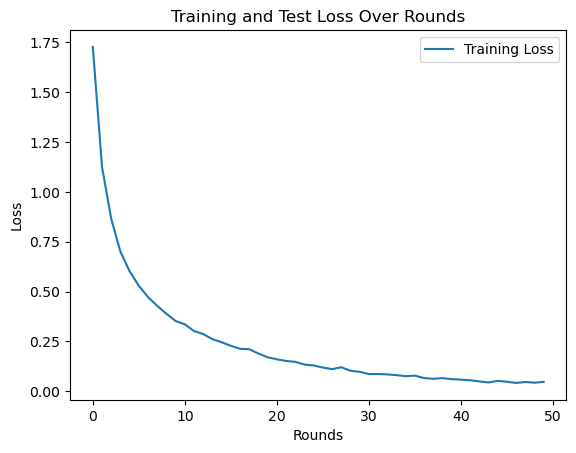

In [17]:
plt.plot(loss_train, label='Training Loss')
#plt.plot(loss_test, label='Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Rounds')
plt.legend()
plt.show()

In [18]:
# Plotting the graphs
def plot_graphs(train_accuracy, test_accuracy, train_loss, test_loss):
    plt.figure(1, figsize=(10,6))
    plt.plot(train_accuracy, label='Train Accuracy', color='red', linewidth=2)
    plt.plot(test_accuracy, label='Test Accuracy', color='blue', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot")
    plt.legend()
    #plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(train_loss, label='Train loss', color='r', linewidth=2)
    plt.plot(test_loss, label='Test loss', color='b', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Epoch Loss Plot")
    plt.legend()

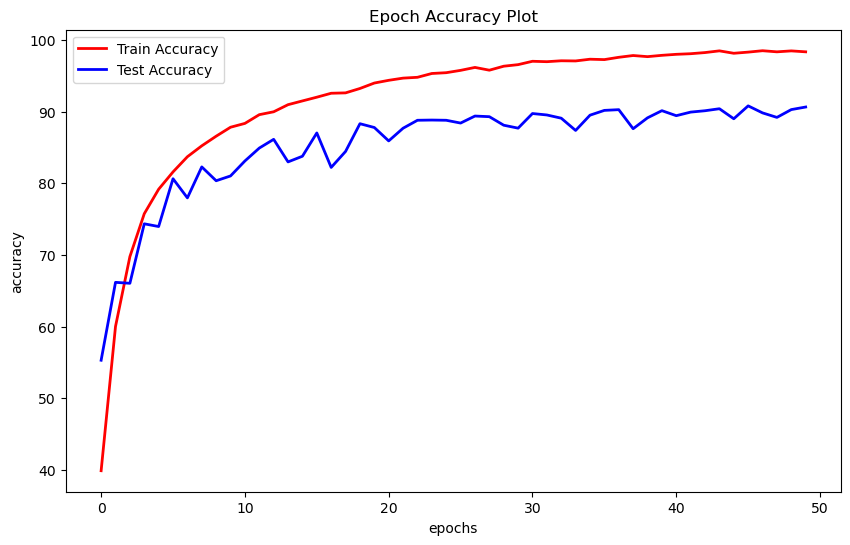

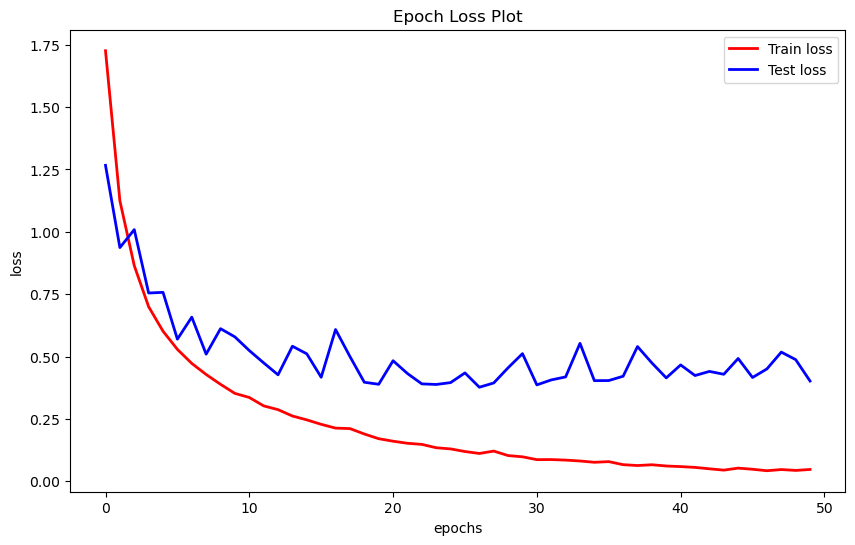

In [19]:
plot_graphs(acc_train, acc_test, loss_train, loss_test)

In [20]:
with open('ResNet9_central_train_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_train}\n")

In [21]:
with open('ResNet9_central_test_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_test}\n")

In [22]:
with open('ResNet9_central_train_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_train}\n") 

In [23]:
with open('ResNet9_central_test_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_test}\n")

In [42]:
# import ast
# with open('test_accuracy.txt', 'r') as file:
#     loaded_t_acc = file.read()
# ast.literal_eval(loaded_t_acc)

In [26]:
# visualize the test result
def evaluate_model(model):
    model.eval()
    total = 0
    correct = 0
    misclassified_examples = []
    # Class labels in CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect misclassified examples
            misclassified = (predicted != labels)
            misclassified_images = images[misclassified]
            misclassified_labels = labels[misclassified]
            predicted_labels = predicted[misclassified]

            for img, true_label, pred_label in zip(misclassified_images, misclassified_labels, predicted_labels):
                if len(misclassified_examples) < 20:  # Limit the number of examples we save
                    misclassified_examples.append((img, true_label, pred_label))

    # Displaying misclassified examples
    fig, axs = plt.subplots(2, 10, figsize=(25, 5))
    for ax, example in zip(axs.flatten(), misclassified_examples):
        img, true_label, pred_label = example
        img = img.cpu().numpy().transpose((1, 2, 0))
        ax.imshow(img * 0.5 + 0.5)  # Unnormalize
        ax.set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}')
        ax.axis('off')

    plt.show()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

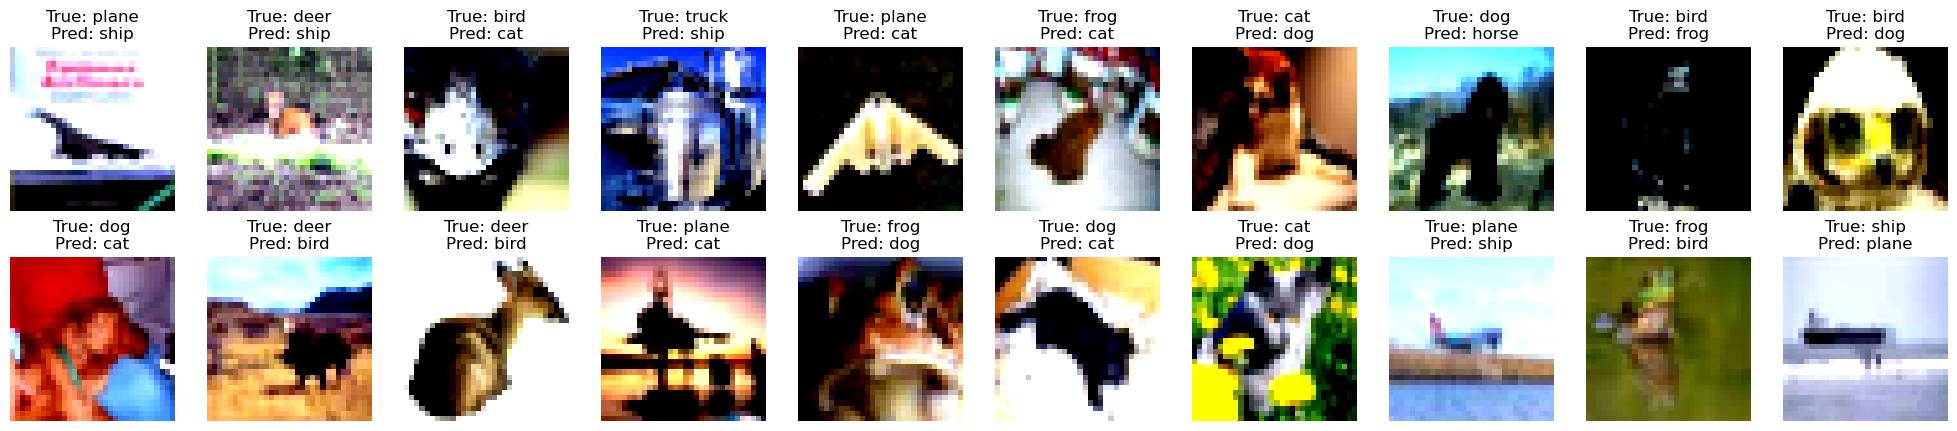

Accuracy of the network on the test images: 93 %


In [27]:
evaluate_model(global_model)

In [25]:
# # To load the entire model
fl_model = torch.load('model_resnet18.pth')
fl_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

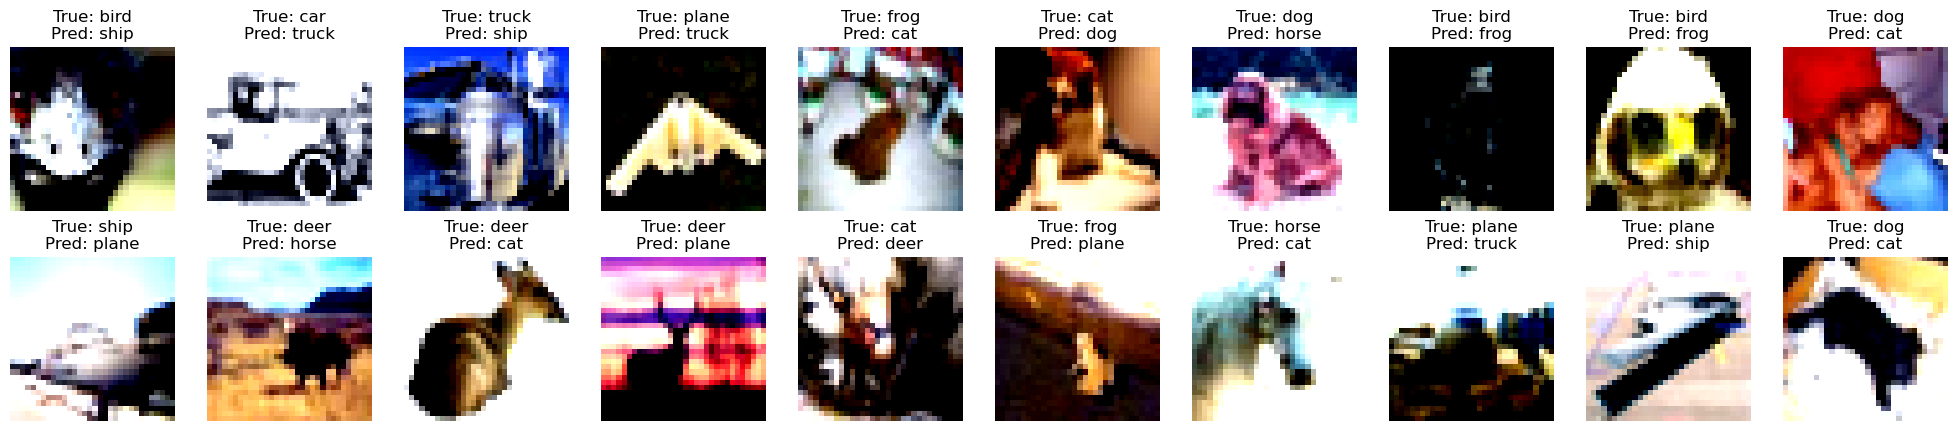

Accuracy of the network on the test images: 91 %


In [27]:
evaluate_model(fl_model.to(device))